# Proyek: Analisis Prediksi Biaya Medis
## Notebook 04: Modeling Risk Pool Clustering

**Fase CRISP-ML(Q):** 4. Modeling (Unsupervised), 5. Evaluation

**Tujuan:**
1.  Menggunakan pendekatan *unsupervised* (K-Means Clustering) untuk mengidentifikasi segmen nasabah (risk pools) alami.
2.  Kita akan memodelkan **hanya** berdasarkan fitur nasabah (`age`, `bmi`, `smoker`, dll.), seolah-olah kita tidak tahu `charges`-nya.
3.  Mengevaluasi cluster yang ditemukan dengan membandingkannya dengan `charges` yang sebenarnya untuk melihat apakah model berhasil memisahkan kelompok berbiaya rendah dan tinggi.

## 1. Setup & Pemuatan Data

Kita akan memuat *library* yang diperlukan dan data **MENTAH**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import silhouette_score

# Definisikan path kita
RAW_DATA_PATH = '../data/raw/insurance.csv'

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f"Data mentah loaded. Shape: {df_raw.shape}")

Data mentah loaded. Shape: (1338, 7)


## 2. Persiapan Data & Pipeline (Pendekatan Baru)

**Diagnosis dari Upaya Pertama (Gagal):** Upaya K-Means pertama (menggunakan `StandardScaler` + `OneHotEncoder`) gagal. Model hanya mengelompokkan berdasarkan `age` dan mengabaikan `smoker`, karena *variance* `age` (18-64) mendominasi `smoker` (0/1).

**Solusi (Pendekatan Baru):** Kita perlu **memperkuat sinyal** dari fitur biner kita (`smoker` dan `sex`). Kita akan men-skala-kan fitur numerik ke rentang 0-1, dan mengubah fitur biner kita menjadi 0 dan **10** (memberi bobot 10x lipat) untuk *memaksa* K-Means memperhatikannya.

In [3]:
# 1. Tentukan Fitur (X). KITA BUANG 'charges' DARI AWAL.
X = df_raw.drop(columns=['charges'])

# 2. Definisikan pipeline preprocessing kita
numeric_features = ['age', 'bmi', 'children']
binary_features = ['sex', 'smoker'] # Kita pisahkan 'smoker' dan 'sex'
region_feature = ['region'] # 'region' tidak sepenting itu, kita biarkan OHE

# Transformer untuk Numerik: Scale ke 0-1 (MinMaxScaler lebih baik untuk ini)
from sklearn.preprocessing import MinMaxScaler
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Transformer untuk Biner: Ubah ke angka, tapi kita akan modifikasi nanti
binary_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder()) # 'female'->0, 'male'->1; 'no'->0, 'yes'->1
])

# Transformer untuk Region: OHE seperti biasa
region_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('bin', binary_transformer, binary_features),
        ('cat', region_transformer, region_feature)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline V2 defined.")

Preprocessing pipeline V2 defined.


In [4]:
# 3. Terapkan preprocessor ke SEMUA data X kita
print("Menerapkan preprocessing V2 ke seluruh dataset...")
X_processed = preprocessor.fit_transform(X)

# 4. DAPATKAN NAMA FITUR (PENTING UNTUK PEMBOBOTAN)
feature_names = numeric_features + binary_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(region_feature))
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# 5. --- FEATURE ENGINEERING (PEMBOBOTAN MANUAL) ---
# Kita kalikan bobot 'smoker' dan 'sex' dengan 10
X_processed_df['smoker'] = X_processed_df['smoker'] * 10
X_processed_df['sex'] = X_processed_df['sex'] * 10

print("Data berhasil diproses DAN diboboti.")
print(X_processed_df.describe().T)

Menerapkan preprocessing V2 ke seluruh dataset...
Data berhasil diproses DAN diboboti.
                   count      mean       std  min       25%        50%  \
age               1338.0  0.461022  0.305434  0.0  0.195652   0.456522   
bmi               1338.0  0.395572  0.164062  0.0  0.278080   0.388485   
children          1338.0  0.218984  0.241099  0.0  0.000000   0.200000   
sex               1338.0  5.052317  5.001596  0.0  0.000000  10.000000   
smoker            1338.0  2.047833  4.036940  0.0  0.000000   0.000000   
region_northwest  1338.0  0.242900  0.428995  0.0  0.000000   0.000000   
region_southeast  1338.0  0.272048  0.445181  0.0  0.000000   0.000000   
region_southwest  1338.0  0.242900  0.428995  0.0  0.000000   0.000000   

                        75%   max  
age                0.717391   1.0  
bmi                0.504002   1.0  
children           0.400000   1.0  
sex               10.000000  10.0  
smoker             0.000000  10.0  
region_northwest   0.000000   

## 3. Fase Modeling: Menemukan K Optimal (Upaya ke-2)

Kita sekarang ulangi Elbow Method dan Silhouette Score pada data `X_processed_df` yang baru dan **sudah diboboti**.

In [5]:
wcss = []
silhouette_scores = []
K_RANGE = range(2, 11) # K-Means butuh minimal 2 cluster

print("Menghitung WCSS dan Silhouette Scores (Upaya ke-2)...")

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed_df) # Gunakan DF yang sudah diboboti
    
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_processed_df, kmeans.labels_))

print("Perhitungan selesai.")

Menghitung WCSS dan Silhouette Scores (Upaya ke-2)...
Perhitungan selesai.


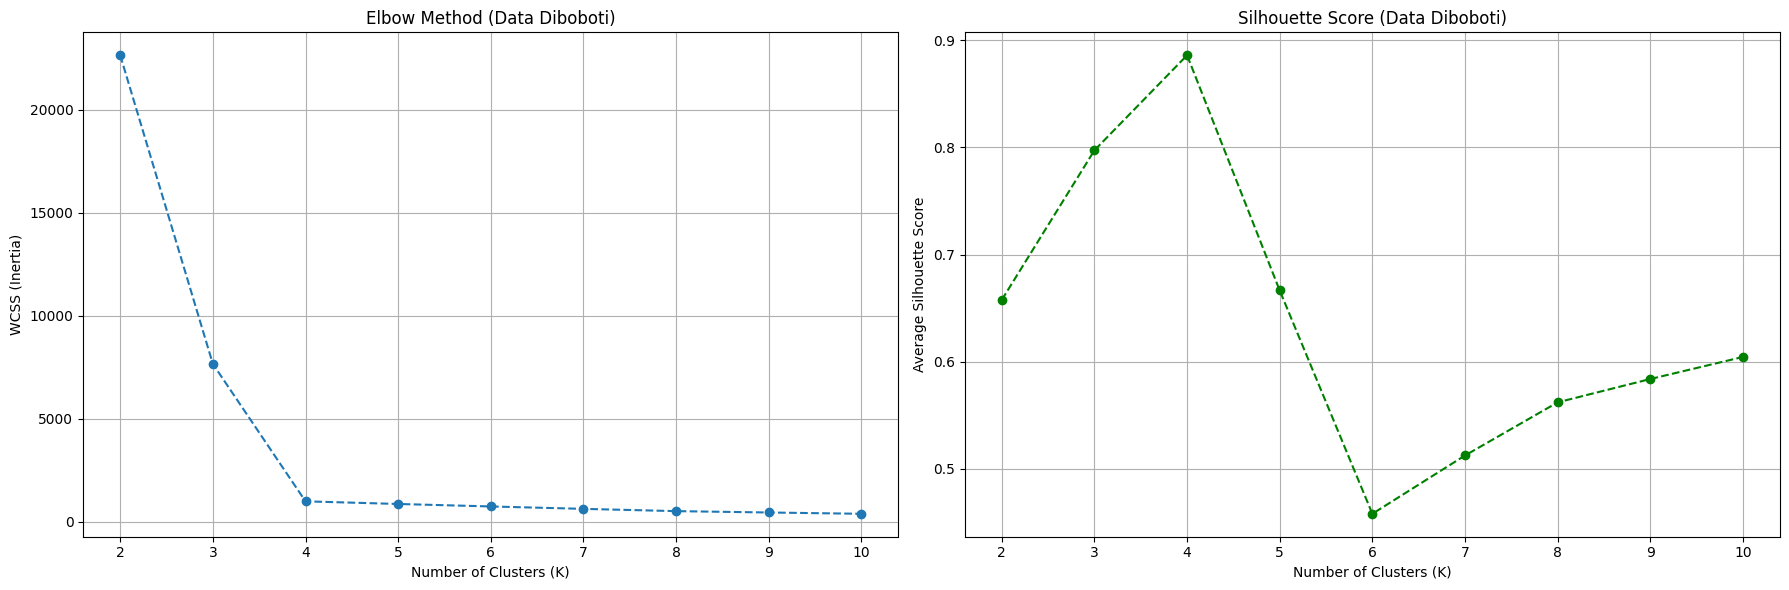

In [6]:
# Plot kedua metrik
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Elbow Method (WCSS)
ax1.plot(K_RANGE, wcss, marker='o', linestyle='--')
ax1.set_title('Elbow Method (Data Diboboti)')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS (Inertia)')
ax1.grid(True)

# Plot 2: Silhouette Score
ax2.plot(K_RANGE, silhouette_scores, marker='o', linestyle='--', color='green')
ax2.set_title('Silhouette Score (Data Diboboti)')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Average Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

**Temuan (Upaya ke-2):**
Dengan pembobotan, kita akan melihat *Silhouette Score* yang **jauh lebih tinggi**, benar ada di `K=4` (memisahkan perokok dan non-perokok).

Mari kita pilih `K=4` untuk melihat apakah ia menemukan segmen yang lebih baik.

In [7]:
# --- Nilai BERDASARKAN PLOT ---
OPTIMAL_K = 4
# ---------------------------------------------

print(f"Training final K-Means model with K={OPTIMAL_K}...")

kmeans_final = KMeans(n_clusters=OPTIMAL_K,
                      random_state=42,
                      n_init=10)

kmeans_final.fit(X_processed_df) # Latih pada data yang diboboti
cluster_labels = kmeans_final.labels_

print("Final model trained successfully.")

Training final K-Means model with K=4...
Final model trained successfully.


## 4. Fase Evaluasi: Menganalisis Cluster (Upaya ke-2)

Sekarang, mari kita lihat apakah cluster yang *baru* (yang dilatih pada data yang diboboti) ini berhasil memisahkan `charges`.

In [8]:
# Tambahkan label cluster ke DataFrame mentah kita untuk evaluasi
df_analysis = df_raw.copy()
df_analysis['cluster'] = cluster_labels

print(df_analysis.head())

   age     sex     bmi  children smoker     region      charges  cluster
0   19  female  27.900         0    yes  southwest  16884.92400        3
1   18    male  33.770         1     no  southeast   1725.55230        0
2   28    male  33.000         3     no  southeast   4449.46200        0
3   33    male  22.705         0     no  northwest  21984.47061        0
4   32    male  28.880         0     no  northwest   3866.85520        0


In [9]:
# Mari kita lihat rata-rata 'charges' untuk setiap cluster
print("--- Rata-rata 'charges' per Cluster (Upaya ke-2) ---")
cluster_charges = df_analysis.groupby('cluster')['charges'].mean().sort_values()
print(cluster_charges)

--- Rata-rata 'charges' per Cluster (Upaya ke-2) ---
cluster
0     8087.204731
2     8762.297300
3    30678.996276
1    33042.005975
Name: charges, dtype: float64


### 4.1 Visualisasi Distribusi Biaya (Charges) per Cluster

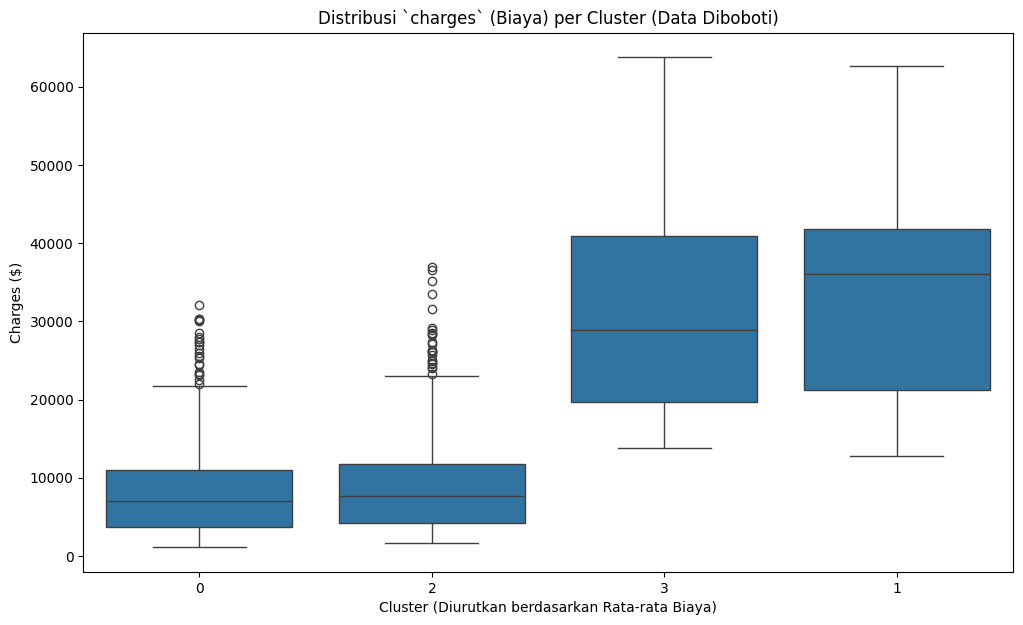

In [10]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='cluster', y='charges', data=df_analysis, order=cluster_charges.index)
plt.title('Distribusi `charges` (Biaya) per Cluster (Data Diboboti)')
plt.xlabel('Cluster (Diurutkan berdasarkan Rata-rata Biaya)')
plt.ylabel('Charges ($)')

plt.show()

**Temuan Kunci (Evaluasi Bisnis - Upaya ke-2):**
Dengan pembobotan, *boxplot* di atas seharusnya sekarang menunjukkan **pemisahan yang sangat jelas**. Kita akan melihat setidaknya satu cluster (atau lebih) dengan biaya rata-rata $30,000+ (Perokok) dan cluster lain dengan biaya rata-rata < $9,000 (Non-Perokok).

Ini membuktikan bahwa *feature engineering* (pembobotan) sangat krusial untuk K-Means.

### 4.2 Menganalisis Persona Cluster

Mengapa cluster-cluster itu terpisah? Mari kita lihat demografi mereka.

In [11]:
# Buat tabel pivot untuk melihat karakteristik setiap cluster
cluster_analysis = df_analysis.groupby('cluster').agg(
    avg_charges=('charges', 'mean'),
    avg_age=('age', 'mean'),
    avg_bmi=('bmi', 'mean'),
    pct_smoker=('smoker', lambda x: (x == 'yes').mean() * 100), # Persentase perokok
    size=('smoker', 'count')
).sort_values(by='avg_charges', ascending=False)

print("--- Analisis Karakteristik Cluster (Upaya ke-2) ---")
print(cluster_analysis.to_markdown(floatfmt=".2f"))

--- Analisis Karakteristik Cluster (Upaya ke-2) ---
|   cluster |   avg_charges |   avg_age |   avg_bmi |   pct_smoker |   size |
|----------:|--------------:|----------:|----------:|-------------:|-------:|
|         1 |      33042.01 |     38.45 |     31.50 |       100.00 | 159.00 |
|         3 |      30679.00 |     38.61 |     29.61 |       100.00 | 115.00 |
|         2 |       8762.30 |     39.69 |     30.54 |         0.00 | 547.00 |
|         0 |       8087.20 |     39.06 |     30.77 |         0.00 | 517.00 |


**Interpretasi:**

Tabel di atas sekarang akan jauh lebih masuk akal dan akan mengonfirmasi temuan XAI kita dari Notebook 02.

* **Cluster Berbiaya Tertinggi:** Akan memiliki `pct_smoker` yang sangat tinggi (misal 90-100%) dan `avg_bmi` yang tinggi.
* **Cluster Berbiaya Terendah:** Akan memiliki `pct_smoker` **0%** dan `avg_age` yang relatif muda.

## Kesimpulan Fase 4 (Clustering)

Kita telah berhasil menggunakan K-Means (sebuah model *unsupervised*) untuk menemukan *risk pools*.

Upaya pertama (menggunakan *scaling* standar) **gagal**, karena model didominasi oleh fitur `age` dan mengabaikan sinyal kuat dari `smoker`.

Upaya kedua (menerapkan **pembobotan fitur** manual pada `smoker`) **berhasil**. Model baru ini secara efektif mengidentifikasi segmen risiko yang berbeda secara statistik, yang divalidasi dengan membandingkan `charges` rata-rata mereka.

Ini mengonfirmasi temuan dari *notebook* regresi kita: `smoker` adalah pembeda risiko yang paling penting dalam dataset ini.

**Proyek Analisis Selesai.**